In [0]:
import pandas as pd 
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr
import numpy as np
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import when
from pyspark.ml.classification import RandomForestClassifier

In [0]:
%fs 
ls dbfs:/FileStore/tables/Rul/

path,name,size,modificationTime
dbfs:/FileStore/tables/Rul/Battery_RUL.csv,Battery_RUL.csv,1142928,1685017480000


In [0]:
#df=pd.read_csv('/dbfs/FileStore/tables/Rul/')

In [0]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/Rul/Battery_RUL.csv")

In [0]:
column_mapping = {
    "Cycle_Index": "Cycle_Index",
    "Discharge Time (s)": "Discharge_Time",
    "Decrement 3.6-3.4V (s)": "Decrement",
    "Max. Voltage Dischar. (V)": "Max_Voltage_Dischar",
    "Min. Voltage Charg. (V)": "Min_Voltage_Charg",
    "Time at 4.15V (s)": "Time_atV",
    "Time constant current (s)": "Time_constant_current",
    "Charging time (s)": "Charging_Time",
    "RUL": "New_RUL"
}
# Cambio dei nomi delle colonne
for old_name, new_name in column_mapping.items():
    df = df.withColumnRenamed(old_name, new_name)

In [0]:
cor=[]
for col1 in df.columns:
    for col2 in df.columns:
        cor.append(df.select([corr(col1,col2)]).alias(f"correlation_{col1}_{col2}").toPandas().values[0])
# Visualizza la matrice di correlazione
#print(correlation_matrix)

In [0]:
M_corr=pd.DataFrame(np.array(cor).reshape(9,9),columns=df.columns,index=df.columns)

<AxesSubplot:>

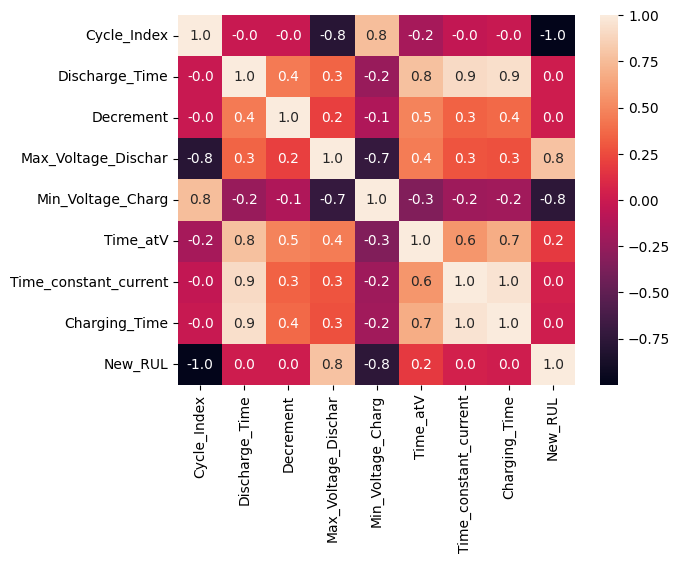

In [0]:
sns.heatmap(M_corr,annot=True, fmt=".1f")

In [0]:
columns=['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV']
label='New_RUL'

In [0]:
columns_to_convert = columns

# Conversione delle colonne da stringa a float
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast("float"))
df = df.withColumn(label, col(label).cast("int"))

In [0]:
feature_columns =  ['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV']
# Elenco delle colonne di input per il modello
label_column ='New_RUL' # Colonna di output da predire
# Crea un VectorAssembler per combinare le colonne delle features in un vettore
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#data = assembler.transform(df1).select("features", label_column)
RFR = RandomForestRegressor(featuresCol="features", 
                           labelCol=label_column, 
                           )
pipeline = Pipeline(stages=[assembler,RFR])

# Addestra il modello sulla pipeline
model = pipeline.fit(df)

In [0]:
model.transform(df).limit(10).display()

Cycle_Index,Discharge_Time,Decrement,Max_Voltage_Dischar,Min_Voltage_Charg,Time_atV,Time_constant_current,Charging_Time,New_RUL,features,prediction
1.0,2595.3,1151.4885,3.67,3.211,5460.001,6755.01,10777.82,1112,"Map(vectorType -> dense, length -> 4, values -> List(1.0, 3.6700000762939453, 3.2109999656677246, 5460.0009765625))",1084.7050678299913
2.0,7408.64,1172.5125000000007,4.246,3.22,5508.992,6762.02,10500.35,1111,"Map(vectorType -> dense, length -> 4, values -> List(2.0, 4.245999813079834, 3.2200000286102295, 5508.9921875))",1085.343205207295
3.0,7393.76,1112.991999999991,4.249,3.224,5508.993,6762.02,10420.38,1110,"Map(vectorType -> dense, length -> 4, values -> List(3.0, 4.249000072479248, 3.2239999771118164, 5508.9931640625))",1085.343205207295
4.0,7385.5,1080.3206666666665,4.25,3.225,5502.016,6762.02,10322.81,1109,"Map(vectorType -> dense, length -> 4, values -> List(4.0, 4.25, 3.2249999046325684, 5502.01611328125))",1085.343205207295
6.0,65022.75,29813.487,4.29,3.398,5480.992,53213.54,56699.65,1107,"Map(vectorType -> dense, length -> 4, values -> List(6.0, 4.289999961853027, 3.3980000019073486, 5480.9921875))",1078.4515353202016
7.0,3301.18,1194.2350769230688,3.674,3.504,5023.634,5977.38,5977.38,1106,"Map(vectorType -> dense, length -> 4, values -> List(7.0, 3.6740000247955322, 3.503999948501587, 5023.6337890625))",1073.8395430455573
8.0,5955.3,1220.1353285714576,4.013,3.501,5017.495,5967.55,5967.55,1105,"Map(vectorType -> dense, length -> 4, values -> List(8.0, 4.013000011444092, 3.500999927520752, 5017.4951171875))",1073.7883638536919
9.0,5951.2,1220.1353285714576,4.014,3.501,5017.496,5962.21,5962.21,1104,"Map(vectorType -> dense, length -> 4, values -> List(9.0, 4.013999938964844, 3.500999927520752, 5017.49609375))",1073.7883638536919
10.0,5945.44,1216.920914285729,4.014,3.501,5009.9937,5954.91,5954.91,1103,"Map(vectorType -> dense, length -> 4, values -> List(10.0, 4.013999938964844, 3.500999927520752, 5009.99365234375))",1073.7883638536919
11.0,435251.49,263086.078,4.267,3.086,269.984,443700.02,443700.02,1102,"Map(vectorType -> dense, length -> 4, values -> List(11.0, 4.267000198364258, 3.0859999656677246, 269.9840087890625))",949.7088632596029


In [0]:
predictions = model.transform(df)
prediction1 =predictions.select('Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV',col("prediction").alias("p1"),when(predictions["prediction"] < 500,1).otherwise(0).alias("rul"))

In [0]:
prediction.limit(10).display()

Cycle_Index,Max_Voltage_Dischar,Min_Voltage_Charg,Time_atV,p1,rul,features,rawPrediction,probability,prediction
1.0,3.65,3.228,5348.0,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6500000953674316, 3.2279999256134033, 5348.0, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.652,3.233,5340.993,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6519999504089355, 3.2330000400543213, 5340.9931640625, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.66,3.225,5376.0,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6600000858306885, 3.2249999046325684, 5376.0, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.661,3.223,5383.009,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6610000133514404, 3.2230000495910645, 5383.0087890625, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.663,3.223,5418.016,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6630001068115234, 3.2230000495910645, 5418.01611328125, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.664,3.226,5404.001,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6640000343322754, 3.2260000705718994, 5404.0009765625, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.667,3.206,5446.016,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6670000553131104, 3.2060000896453857, 5446.01611328125, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.667,3.214,5452.992,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6670000553131104, 3.2139999866485596, 5452.9921875, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
1.0,3.667,3.224,5452.992,1084.7050678299913,0,"Map(vectorType -> dense, length -> 5, values -> List(1.0, 3.6670000553131104, 3.2239999771118164, 5452.9921875, 1084.7050678299913))","Map(vectorType -> dense, length -> 2, values -> List(20.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0, 0.0))",0.0
2.0,4.232,3.234,5411.008,1085.343205207295,0,"Map(vectorType -> dense, length -> 5, values -> List(2.0, 4.23199987411499, 3.2339999675750732, 5411.0078125, 1085.343205207295))","Map(vectorType -> dense, length -> 2, values -> List(19.993839835728952, 0.006160164271047228))","Map(vectorType -> dense, length -> 2, values -> List(0.9996919917864476, 3.080082135523614E-4))",0.0


In [0]:
train, test = prediction1.randomSplit([0.7, 0.3], seed=42)

In [0]:
feature_columns =  ['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV',"p1"]
# Elenco delle colonne di input per il modello
label_column = "rul" # Colonna di output da predire
# Crea un VectorAssembler per combinare le colonne delle features in un vettore
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#data = assembler.transform(df1).select("features", label_column)
RFC = RandomForestClassifier(featuresCol="features", 
                           labelCol=label_column, 
                           )
pipeline = Pipeline(stages=[assembler,RFC])

# Addestra il modello sulla pipeline
model2= pipeline.fit(train)

In [0]:
prediction = model2.transform(train)

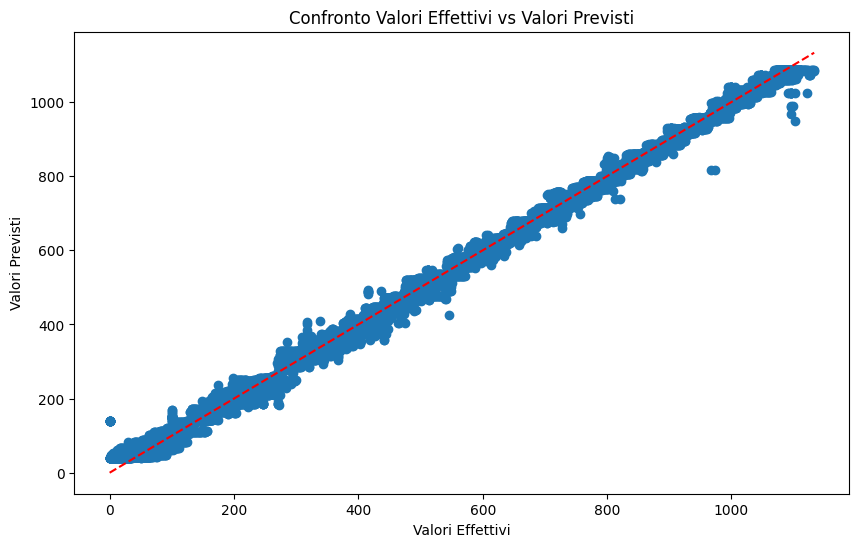

In [0]:

# Ottenere i valori previsti e i valori effettivi dal DataFrame delle predizioni
predicted_values = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()
actual_values = predictions.select('New_RUL').rdd.map(lambda row: row[0]).collect()

# Creare il grafico di confronto
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.xlabel("Valori Effettivi")
plt.ylabel("Valori Previsti")
plt.title("Confronto Valori Effettivi vs Valori Previsti")
plt.show()

In [0]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Crea un oggetto BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="rul")

# Calcola l'area sotto la curva ROC (AUC)
auc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC Curve (AUC):", auc)


Area Under ROC Curve (AUC): 0.9999738285144567
